## Part B: Land Cover Modeling

### Summary of Work

In Part A, data preprocessing is performed on the original land cover dataset (2448 by 2448 RGB) satellite images with its corresponding (2448 by 2448 RGB) segmentation mask. These images are being resized to 224 by 224 RGB to accomodate to the deep learning task.

In Part B-VGG, a 4 stage VGG U-net model is trained and achieved a validation accuracy of 72\%.

### Next Steps

In subsequent sprints, I outline the plan:

* Develop the computation for mean IoU using the sample GT labels and predicted labels
* Apply transfer learning to get improved accuracy and IoU (ResNet, EfficientNet???)
* Explore other light-weight models like MobileNet for deployment

---

### Notes

Below are the class labels:
The RGB values have been normalized from 0-255 to 0-1.

```
# RGB to Class Mapping
rgb_to_class = {
    (0, 1, 1): 1,  # urban_land
    (1, 1, 0): 2,  # agriculture_land
    (1, 0, 1): 3,  # rangeland
    (0, 1, 0): 4,  # forest_land
    (0, 0, 1): 5,  # water
    (1, 1, 1): 6,  # barren_land
    (0, 0, 0): 7  # unknown
} # one-indexing
```

### Mount Google Drive and load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
npy_folder = '/content/drive/MyDrive/ad-hoc_data/archive'

In [ ]:
import numpy as np

X_npy = np.load(npy_folder + "/x_images.npy")
y_npy = np.load(npy_folder + "/y_masks.npy")

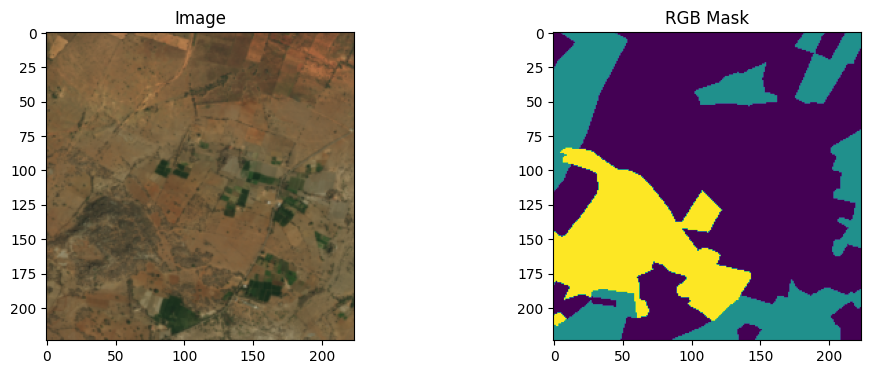

[[1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 1. 1. 1.]
 [2. 2. 2. ... 1. 1. 1.]
 [2. 2. 2. ... 1. 1. 1.]]


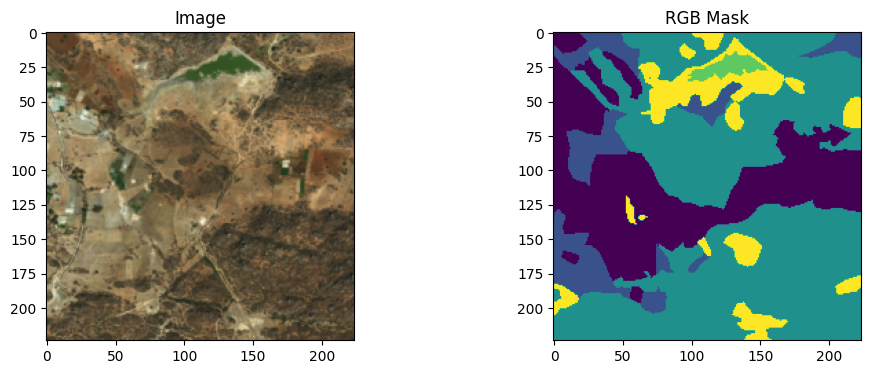

[[1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 [1. 1. 1. ... 2. 2. 2.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]


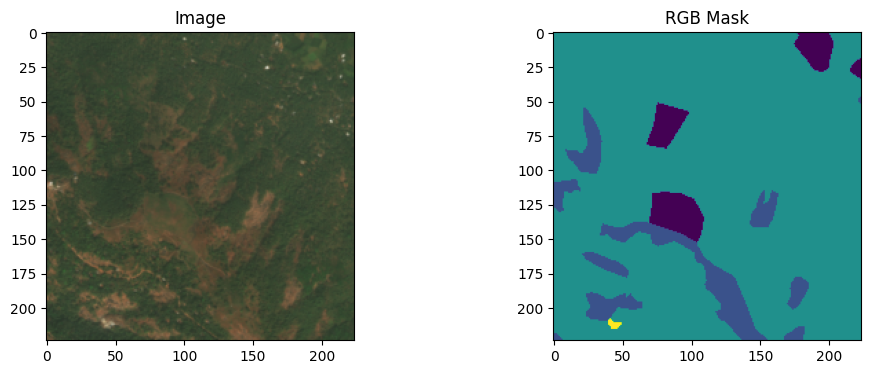

[[3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [2. 2. 2. ... 3. 3. 3.]
 [2. 2. 2. ... 3. 3. 3.]
 [2. 2. 2. ... 3. 3. 3.]]


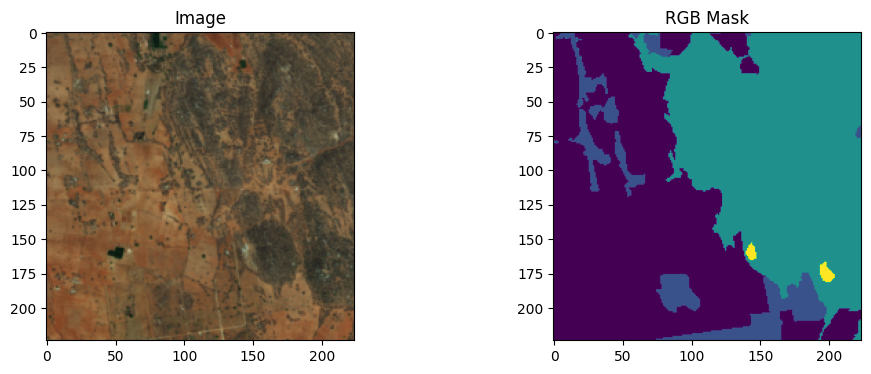

[[1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 ...
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 3. 3. 3.]]


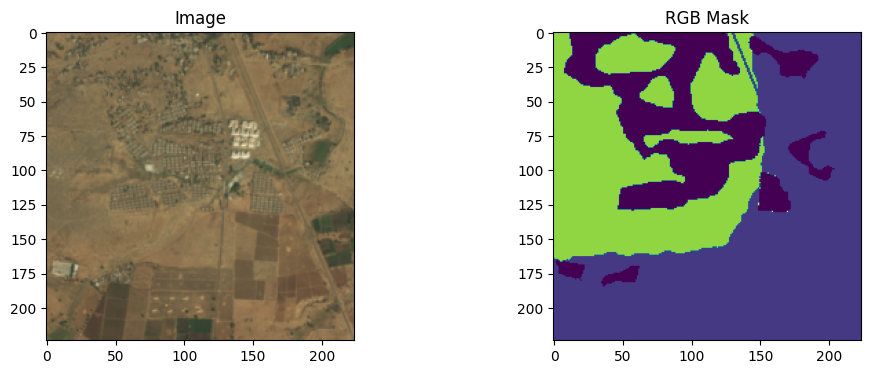

[[5. 5. 5. ... 1. 1. 1.]
 [5. 5. 5. ... 1. 1. 1.]
 [5. 5. 5. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


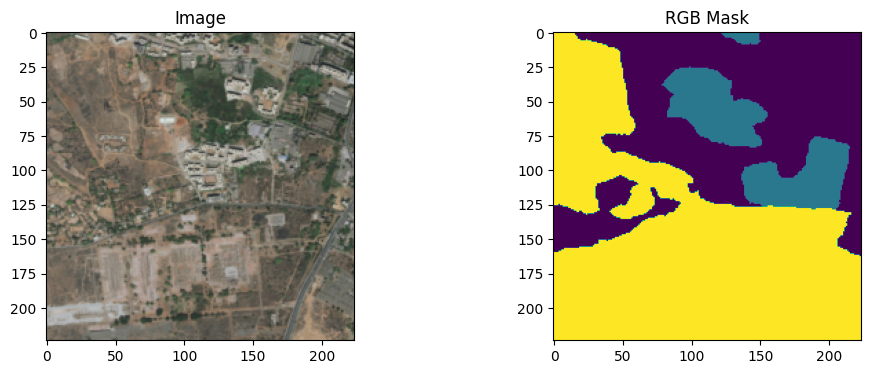

[[5. 5. 5. ... 0. 0. 0.]
 [5. 5. 5. ... 0. 0. 0.]
 [5. 5. 5. ... 0. 0. 0.]
 ...
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]]


In [ ]:
import matplotlib.pyplot as plt

images_list = [19, 181, 39, 258, 732, 454]

for image_idx in images_list:
    # Load the image and mask
    image = X_npy[image_idx].astype(np.float32)
    rgb_mask = y_npy[image_idx].astype(np.float32)

    # Example: Display the images
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_mask, cmap='viridis')


    plt.title('RGB Mask')

    plt.show()
    print(rgb_mask)


### Define VGG-16

Model adapted from : https://www.kaggle.com/code/aithammadiabdellatif/vgg16-u-net

You can build the encoder as shown below. (Described steps from Thomas James Advanced Coursera Segmentation course)

* You will create 5 blocks with increasing number of filters at each stage.
* The number of convolutions, filters, kernel size, activation, pool size and pool stride will remain constant.
* You will load the pretrained weights after creating the VGG 16 network.
* Additional convolution layers will be appended to extract more features.
* The output will contain the output of the last layer and the previous four convolution blocks.

The layers of VGG16 are:

```

['input_67', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1',

'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3',

'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool',

 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
```

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from keras.layers import Dropout

def conv_block(inputs,filterCount):
    x = Conv2D(filterCount,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filterCount,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)      # I added this for hyperparameter tuning
    x = Activation("relu")(x)

    return x

def decoder_block(inputs,skip_features,filter_count):

    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filter_count)
    return x

def unet_vgg16(input_shape, num_classes=7):
    inputs = Input(input_shape)
    print(inputs.shape)
    vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor = inputs)
    #vgg16.summary()
    # the encoder
    skip1 = vgg16.get_layer("block1_conv2").output
    print(skip1.shape)
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output
    # the center
    center = vgg16.get_layer("block5_conv3").output

    # the decoder
    d1 = decoder_block(center,skip4,512)
    d2 = decoder_block(d1,skip3,256)
    d3 = decoder_block(d2,skip2,128)
    d4 = decoder_block(d3,skip1,64)
    #output
    conv1 = Conv2D(32,3,padding="same")(d4)
    conv2 = Conv2D(16,3,padding="same")(conv1)
    conv3 = Conv2D(num_classes,3,padding="same")(conv2)
    outputs = Activation('softmax')(conv3)
    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [ ]:
# This step is for me to view all the layers within the VGG16 network,
# i.e the shape of the output of each layer
input_shape = (224,224,3)
model = unet_vgg16(input_shape)
model.summary()


(None, 224, 224, 3)
58889256/58889256 [==============================] - 3s 0us/step
(None, 224, 224, 64)
Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Assuming input images are 224x224 with 3 channels
input_shape = (224, 224, 3)
num_classes = 7  # 7 classes based on your provided RGB mapping

# One-Hot Encode Integer Masks
y_one_hot = to_categorical(y_npy, num_classes=num_classes)

print(y_one_hot.shape)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_npy, y_one_hot, test_size=0.2, random_state=42)

(803, 224, 224, 7)


In [ ]:
from keras import backend as K

def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [ ]:
import os
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler


training_session_id = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
training_session_folder = '/content/drive/MyDrive/ad-hoc_data/archive/train_%s' % (training_session_id)
os.makedirs(training_session_folder, exist_ok=True)

# Learning rate scheduler function
def lr_scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# # Learning rate scheduler function
# def lr_scheduler(epoch, lr, factor=.95):
#     if epoch % 3 == 0 and epoch > 0:
#         return lr * factor  # Adjust the factor as needed
#     return lr

# Learning rate scheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Callbacks list with ModelCheckpoint and LearningRateScheduler
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/u_net_model.{epoch:04d}-acc-{accuracy:4.2f}-val_acc-{val_accuracy:4.2f}-loss-{val_loss:4.2f}.h5',
        monitor='val_loss', save_best_only=True),
    lr_scheduler_callback
]


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

print("Shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)\

# del y_one_hot, X_npy, y_npy

# Compile the model with Categorical Crossentropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', jaccard_coef])

Shapes:
X_train: (642, 224, 224, 3)
X_val: (161, 224, 224, 3)
y_train: (642, 224, 224, 7)
y_val: (161, 224, 224, 7)


In [ ]:
# Training loop
epochs = 100
batch_size = 32

# Use the iterators in your training loop
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

# Create iterators for the training and validation data
train_iterator = datagen.flow(X_train, y_train, batch_size=batch_size)
val_iterator = datagen.flow(X_val, y_val, batch_size=batch_size)

# Training with fit function
history = model.fit(train_iterator, steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator, validation_steps=validation_steps,
                    epochs=epochs, callbacks=callbacks_list)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.4781 - accuracy: 0.5200 - jaccard_coef: 0.2485

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 119s 2s/step - loss: 1.4781 - accuracy: 0.5200 - jaccard_coef: 0.2485 - val_loss: 9.0568 - val_accuracy: 0.4952 - val_jaccard_coef: 0.3237 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 35s 2s/step - loss: 1.2184 - accuracy: 0.6002 - jaccard_coef: 0.2810 - val_loss: 70.2461 - val_accuracy: 0.1119 - val_jaccard_coef: 0.0594 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 35s 2s/step - loss: 1.1556 - accuracy: 0.6139 - jaccard_coef: 0.2947 - val_loss: 82.4902 - val_accuracy: 0.1159 - val_jaccard_coef: 0.0617 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 35s 2s/step - loss: 1.1776 - accuracy: 0.6085 - jaccard_coef: 0.2813 - val_loss: 32.7375 - val_accuracy: 0.1113 - val_jaccard_coef: 0.0594 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 36s 2s/step - loss: 1.2042 - accuracy: 0.5996 - jaccard_coef: 0.2661 - val_loss: 2.3428 - val_accuracy: 0.5752 - val_jaccard_coef: 0.3387 -

In [ ]:
# 3 - Load checkpointed model for continuation of training or predict validation set
from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/ad-hoc_data/archive/train_2024-02-14 05-29-53/u_net_model.0092-acc-0.74-val_acc-0.74-loss-0.82.h5')

1/1 [==============================] - 3s 3s/step


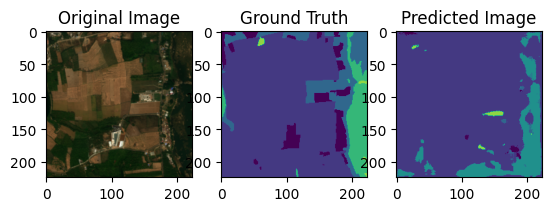

[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [2 2 2 ... 5 6 6]
 [2 2 2 ... 5 5 6]
 [2 2 2 ... 5 5 6]]
[[2 2 2 ... 2 4 6]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 4]
 ...
 [2 2 4 ... 2 2 2]
 [2 2 4 ... 2 2 2]
 [4 2 4 ... 2 2 3]]
The unique GT class labels are [1 2 3 5 6]
The unique predicted class labels are [1 2 3 4 5 6]
1/1 [==============================] - 0s 21ms/step


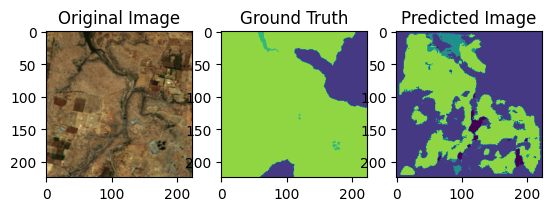

[[6 6 6 ... 2 2 2]
 [6 6 6 ... 2 2 2]
 [6 6 6 ... 2 2 2]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [2 5 6]
The unique predicted class labels are [1 2 3 4 6]
1/1 [==============================] - 0s 19ms/step


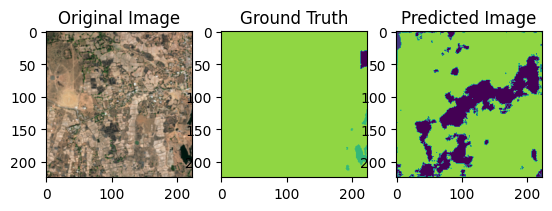

[[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]
[[4 2 2 ... 6 6 6]
 [2 2 2 ... 6 6 2]
 [2 2 2 ... 6 6 6]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 3 ... 2 2 2]]
The unique GT class labels are [1 5 6]
The unique predicted class labels are [1 2 3 4 6]
1/1 [==============================] - 0s 20ms/step


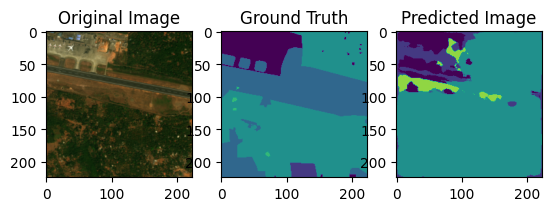

[[1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
[[2 2 2 ... 2 4 2]
 [2 2 2 ... 2 4 2]
 [2 2 2 ... 4 2 4]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [1 2 3 4 5]
The unique predicted class labels are [1 2 3 4 6]
1/1 [==============================] - 0s 19ms/step


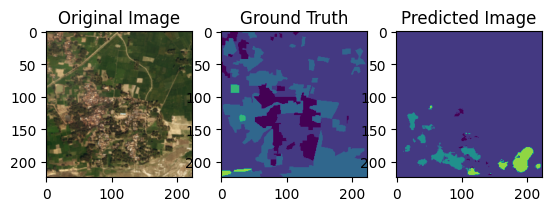

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [6 6 6 ... 3 3 3]
 [6 6 6 ... 3 3 3]
 [6 3 3 ... 3 3 2]]
[[2 2 2 ... 2 4 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [1 2 3 5 6]
The unique predicted class labels are [1 2 3 4 6]
1/1 [==============================] - 0s 20ms/step


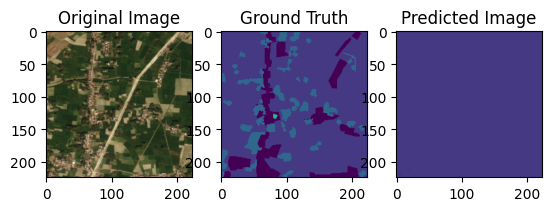

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [1 2 3 5]
The unique predicted class labels are [1 2]
1/1 [==============================] - 0s 19ms/step


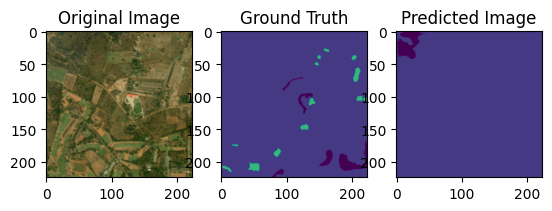

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [1 2 5]
The unique predicted class labels are [1 2]
1/1 [==============================] - 0s 21ms/step


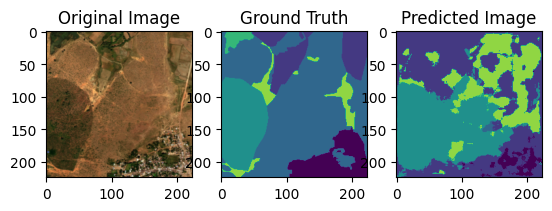

[[3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]
 ...
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 4 ... 2 2 2]
 [2 2 4 ... 2 2 2]
 [4 2 4 ... 2 2 2]]
The unique GT class labels are [1 2 3 4 5 6]
The unique predicted class labels are [1 2 3 4 6]
1/1 [==============================] - 0s 21ms/step


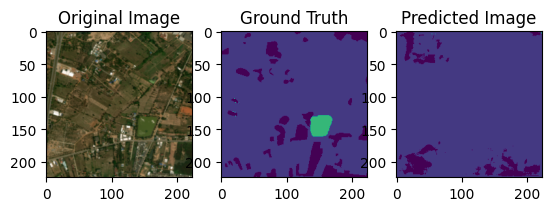

[[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [2 2 2 ... 2 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]
[[2 2 2 ... 2 6 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 1 2 6]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [1 2 5 7]
The unique predicted class labels are [1 2 4 6]
1/1 [==============================] - 0s 18ms/step


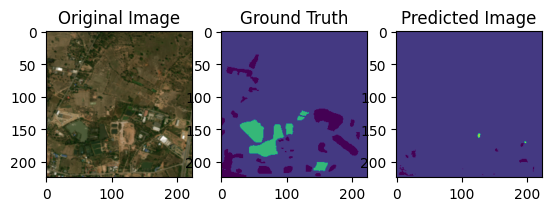

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [1 2 5 7]
The unique predicted class labels are [1 2 6]
1/1 [==============================] - 0s 24ms/step


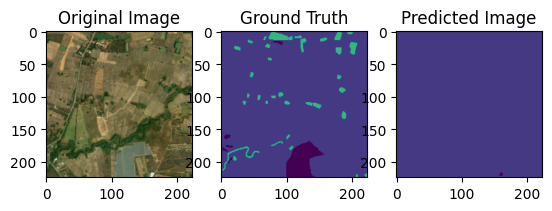

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 5 5 5]
 [2 2 2 ... 5 5 5]
 [2 2 2 ... 2 5 5]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [1 2 5 7]
The unique predicted class labels are [1 2]
1/1 [==============================] - 0s 19ms/step


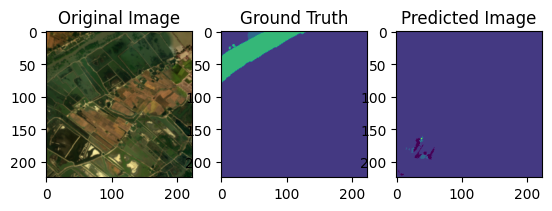

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 3]]
The unique GT class labels are [2 3 5]
The unique predicted class labels are [1 2 3 6]
1/1 [==============================] - 0s 19ms/step


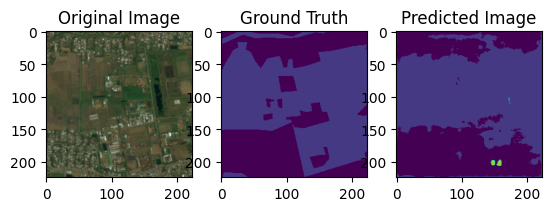

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 2 2 ... 2 6 2]
 [2 1 1 ... 2 2 2]
 [2 2 1 ... 1 2 1]
 ...
 [2 2 3 ... 2 2 1]
 [2 2 2 ... 2 2 1]
 [2 2 3 ... 2 2 2]]
The unique GT class labels are [1 2]
The unique predicted class labels are [1 2 3 4 6]
1/1 [==============================] - 0s 24ms/step


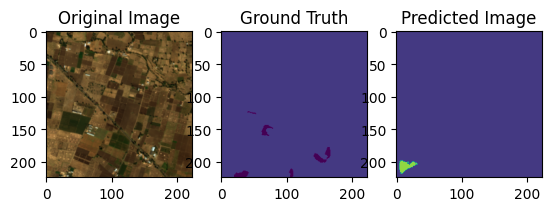

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [1 2]
The unique predicted class labels are [2 6]
1/1 [==============================] - 0s 18ms/step


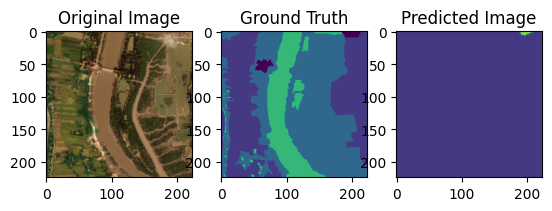

[[3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [1 2 3 5]
The unique predicted class labels are [2 6]
1/1 [==============================] - 0s 19ms/step


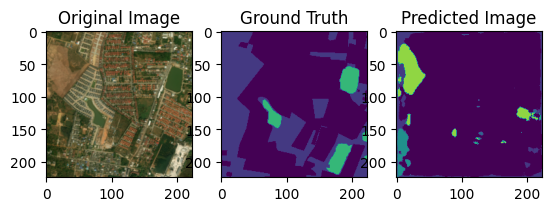

[[2 2 2 ... 1 1 2]
 [2 2 2 ... 1 1 2]
 [2 2 2 ... 1 1 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
[[2 2 2 ... 2 1 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 4 ... 2 2 2]
 [2 2 4 ... 2 2 2]
 [4 2 4 ... 2 2 2]]
The unique GT class labels are [1 2 5]
The unique predicted class labels are [1 2 3 4 6]
1/1 [==============================] - 0s 19ms/step


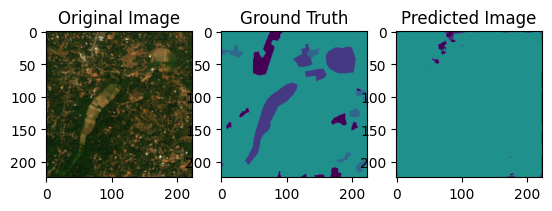

[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]]
[[4 2 2 ... 2 4 2]
 [2 2 2 ... 2 4 2]
 [2 2 2 ... 2 2 4]
 ...
 [2 2 4 ... 2 2 2]
 [2 2 4 ... 4 2 2]
 [2 2 4 ... 2 2 2]]
The unique GT class labels are [1 2 3 4]
The unique predicted class labels are [1 2 3 4]
1/1 [==============================] - 0s 20ms/step


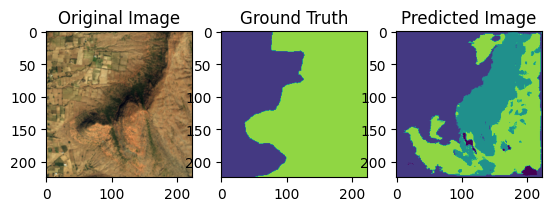

[[2 2 2 ... 6 6 6]
 [2 2 2 ... 6 6 6]
 [2 2 2 ... 6 6 6]
 ...
 [2 2 2 ... 6 6 6]
 [2 2 2 ... 6 6 6]
 [2 2 2 ... 6 6 6]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 6]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [2 6]
The unique predicted class labels are [1 2 3 4 5 6]
1/1 [==============================] - 0s 20ms/step


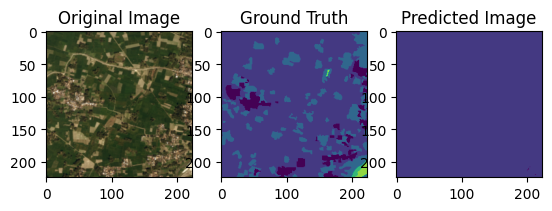

[[2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 ...
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]]
[[2 2 2 ... 2 4 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [1 2 3 5 6]
The unique predicted class labels are [1 2 4]
1/1 [==============================] - 0s 19ms/step


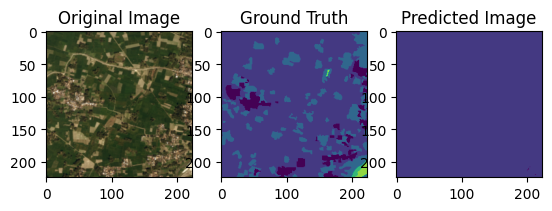

[[2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 ...
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]]
[[2 2 2 ... 2 4 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
The unique GT class labels are [1 2 3 5 6]
The unique predicted class labels are [1 2 4]


In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

# Prediction loop
num_samples_to_predict = 20  # change here for the number of images to predict

for _ in range(num_samples_to_predict):
    # Generate a random index for prediction
    random_index = np.random.randint(0, len(X_val))

    # Select a sample from the validation set
    sample_image = X_val[random_index]
    sample_one_hot_label = y_val[random_index]

    # Expand dimensions to match the model input shape
    sample_image = np.expand_dims(sample_image, axis=0)

    # Make the prediction
    predictions = model.predict(sample_image)

    # Convert predictions to categorical indices
    predicted_label_indices = np.argmax(predictions, axis=-1) + 1

    # Convert one-hot encoded label to categorical indices
    sample_label_indices = np.argmax(sample_one_hot_label, axis=-1) + 1

    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(array_to_img(sample_image.squeeze()))
    plt.title("Original Image")

    # Display the ground truth (categorical indices, one-indexed)
    plt.subplot(1, 3, 2)
    plt.imshow(sample_label_indices, cmap='viridis', vmin=1, vmax=7)
    plt.title("Ground Truth")

    # Display the predicted image (categorical index, one-indexed)
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_label_indices.squeeze(), cmap='viridis', vmin=1, vmax=7)
    plt.title("Predicted Image")

    plt.show()
    print(sample_label_indices)
    print(predicted_label_indices.squeeze())
    print(f'The unique GT class labels are {np.unique(sample_label_indices)}')
    print(f'The unique predicted class labels are {np.unique(predicted_label_indices.squeeze())}')

Display classification metric report

In [ ]:
# Create list of land cover categorical labels that correspond to the predicted index labels
labels = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

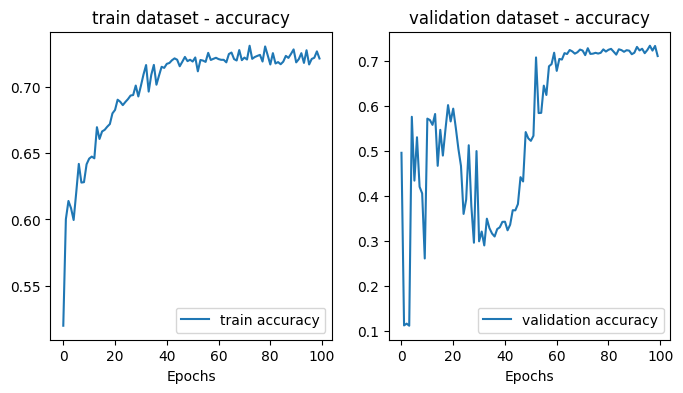

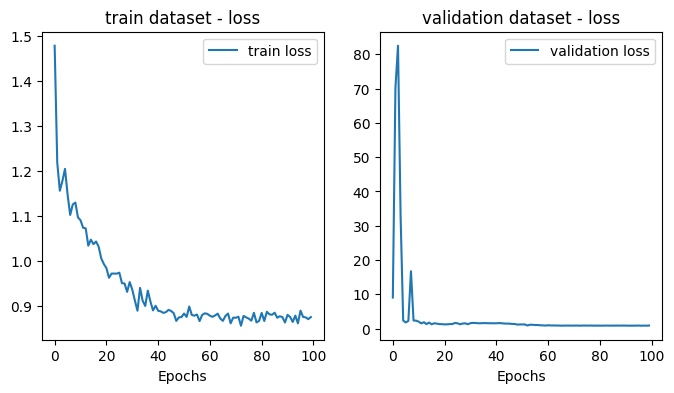

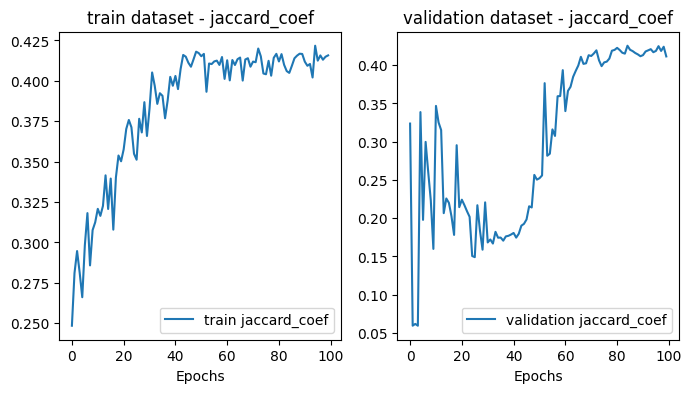

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def display_metrics(history, metric='accuracy'):
    plt.figure(figsize=(8, 4))

    # Train Data Metrics
    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric], label=f'train {metric}')
    plt.title(f'train dataset - {metric}')
    plt.xlabel('Epochs')
    plt.legend()

    # Test Data Metrics
    plt.subplot(1, 2, 2)
    val_metric = f'val_{metric}'  # Use val_accuracy and val_loss for validation metrics
    plt.plot(history.history[val_metric], label=f'validation {metric}')
    plt.title(f'validation dataset - {metric}')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

# Assuming `history` is the history object returned by model.fit
display_metrics(history, 'accuracy')
display_metrics(history, 'loss')
display_metrics(history, 'jaccard_coef')


Display classification report and confusion matrix

In [ ]:
# convert y_train and y_val from one-hot encoding formatted predictions to categorical labels

# Convert predictions to categorical indices
# y_train_index = np.argmax(y_train, axis=-1)
# y_val_index = np.argmax(y_val, axis=-1)

In [ ]:
# y_train_index = y_train.reshape(1, -1)
# y_val_index = y_val.reshape(1, -1)

print(y_train.shape)

(642, 224, 224, 7)


In [ ]:
import numpy as np

# Assuming your array is named 'original_array'
original_shape = (2, 256, 256, 7)
original_array = np.random.random(original_shape)

# Reshape the array
flattened_array = original_array.reshape(-1, original_shape[-1])

print(original_shape[-1])

print(flattened_array.shape)


7
(131072, 7)


6/6 [==============================] - 2s 384ms/step


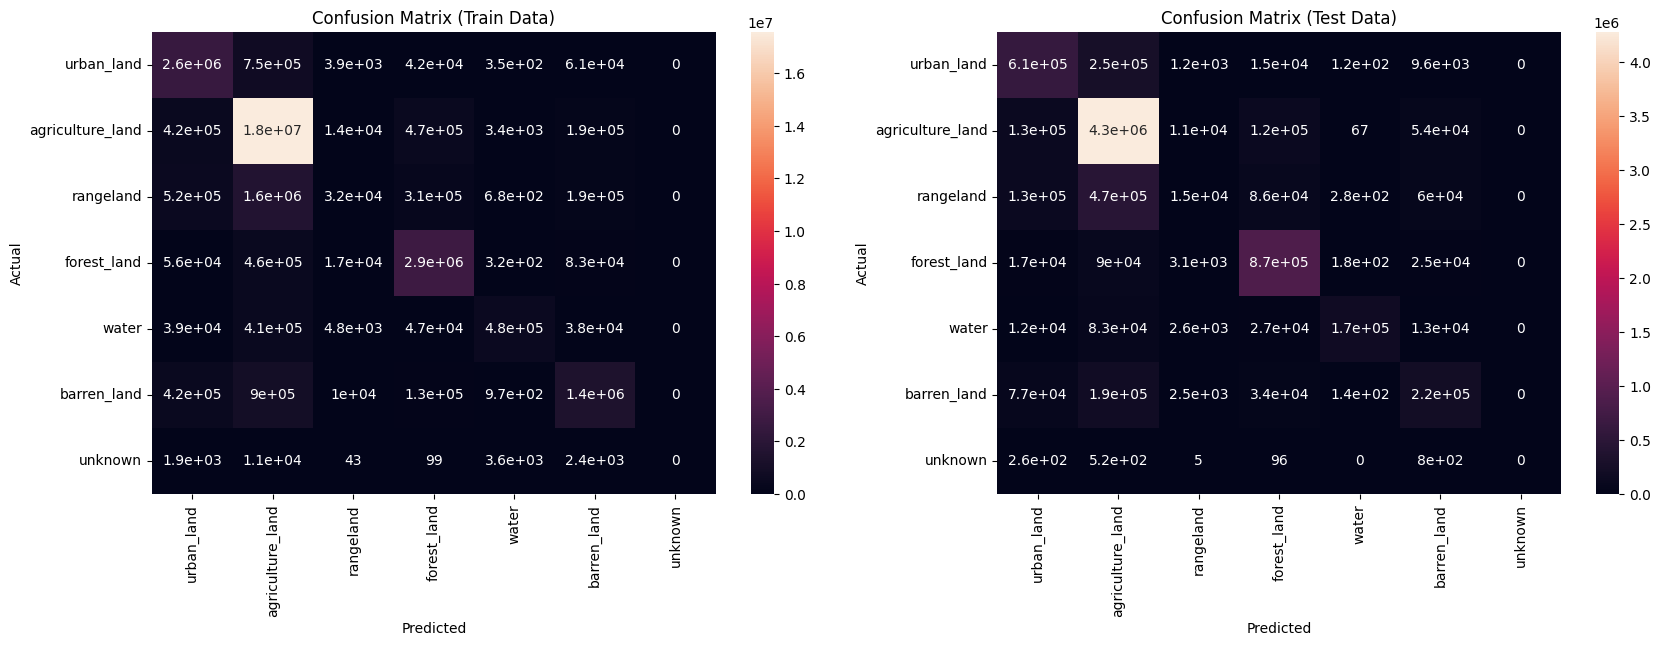

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
import seaborn as sns
import pandas as pd


def display_confusion_matrix(keras_model, x_train, y_train, x_test, y_test, labels):

    actual_y_train = keras_model.predict(x_train)
    actual_y_test = keras_model.predict(x_test)

    plt.figure(figsize=(20,6))

    labels = np.array(labels)


    # Convert the target labels into the categorical index
    #
    y_train_index = y_train.argmax(axis=-1)
    actual_y_train_index = actual_y_train.argmax(axis=-1)
    y_test_index = y_test.argmax(axis=-1)
    actual_y_test_index = actual_y_test.argmax(axis=-1)


    # Convert the matrix to an column array
    y_train_index = y_train_index.reshape(1, -1).flatten()
    actual_y_train_index = actual_y_train_index.reshape(1, -1).flatten()

    y_test_index = y_test_index.reshape(1, -1).flatten()
    actual_y_test_index = actual_y_test_index.reshape(1, -1).flatten()


    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train_index, actual_y_train_index)

    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Print the second Confusion Matrix for the test data
    #
    cm = confusion_matrix(y_test_index, actual_y_test_index)


    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.show()


# Exclude the O tags from the confusion matrix.
#
display_confusion_matrix(model, X_train, y_train, X_val, y_val, labels)

In [ ]:
# 3 - Load checkpointed model for continuation of training or predict validation set
from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/ad-hoc_data/archive/train_2024-02-14 05-29-53/u_net_model.0092-acc-0.74-val_acc-0.74-loss-0.82.h5')

6/6 [==============================] - 2s 383ms/step


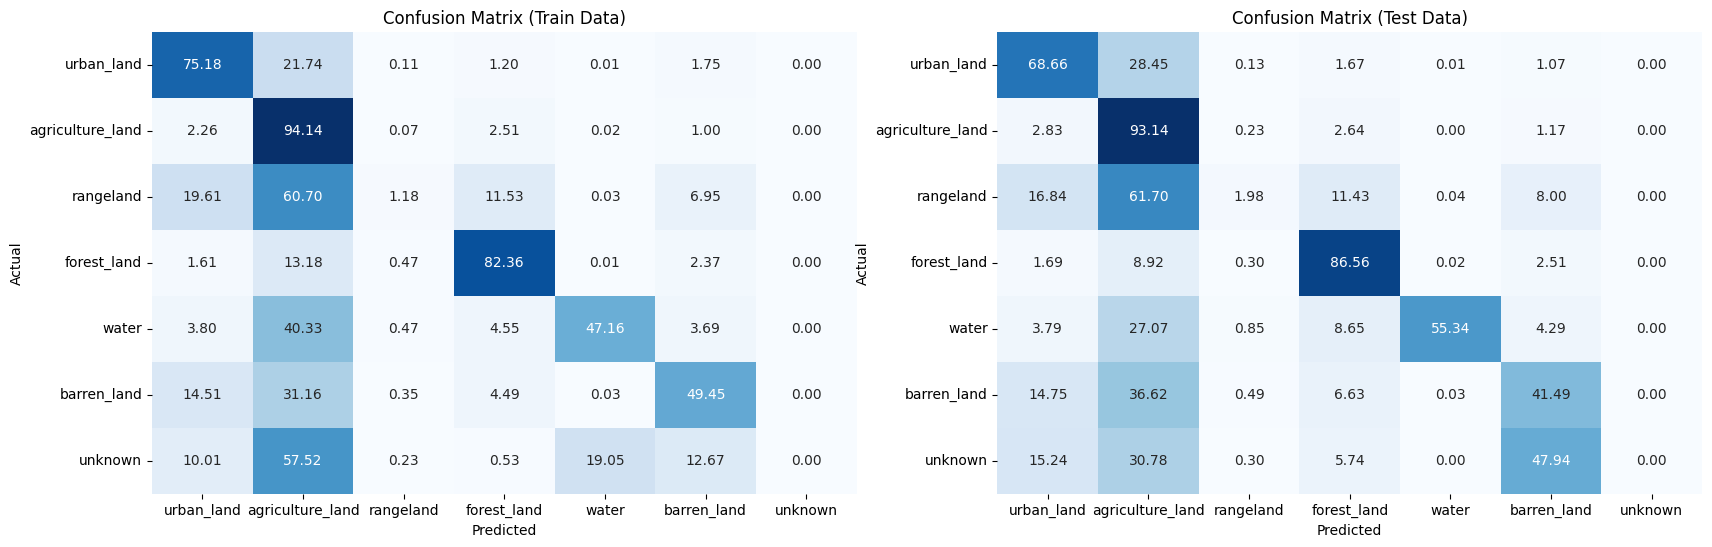

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import seaborn as sns
import pandas as pd

def display_confusion_matrix_as_pct(keras_model, x_train, y_train, x_test, y_test, labels):
    actual_y_train = keras_model.predict(x_train)
    actual_y_test = keras_model.predict(x_test)

    plt.figure(figsize=(20, 6))

    labels = np.array(labels)

    # Convert the target labels into the categorical index
    y_train_index = y_train.argmax(axis=-1)
    actual_y_train_index = actual_y_train.argmax(axis=-1)
    y_test_index = y_test.argmax(axis=-1)
    actual_y_test_index = actual_y_test.argmax(axis=-1)

    # Convert the matrix to a column array
    y_train_index = y_train_index.reshape(1, -1).flatten()
    actual_y_train_index = actual_y_train_index.reshape(1, -1).flatten()
    y_test_index = y_test_index.reshape(1, -1).flatten()
    actual_y_test_index = actual_y_test_index.reshape(1, -1).flatten()

    def plot_confusion_matrix(ax, y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100  # Calculate percentages

        cm_df = pd.DataFrame(cm_percentage, labels, labels)
        sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax)
        ax.set_title(title)
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')

    # Plot the first Confusion Matrix for the training data
    ax1 = plt.subplot(1, 2, 1)
    plot_confusion_matrix(ax1, y_train_index, actual_y_train_index, 'Confusion Matrix (Train Data)')

    # Plot the second Confusion Matrix for the test data
    ax2 = plt.subplot(1, 2, 2)
    plot_confusion_matrix(ax2, y_test_index, actual_y_test_index, 'Confusion Matrix (Test Data)')

    plt.show()

# Assuming you have x_train, y_train, x_test, y_test, labels defined
# model is your trained Keras model
display_confusion_matrix_as_pct(model, X_train, y_train, X_val, y_val, labels)


## Further Work and next steps

* ~~Apply transfer learning to get improved accuracy and IoU (VGG and ResNet)~~
* Explore other light-weight models like MobileNet and ~~EfficientNet~~
* ~~Code refactoring and create application `app.py` and other library files~~
* ~~Simple Deployment Case - build Gradio interface for simple user testing~~
* Full Deployment in Docker (build AI server, Flask Server and Web Server containers) Mridul doing, I need to check his work and help him troubleshoot by doing